In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("../data/processed/train_FD001_processed.pkl")

In [3]:
target = "RUL"

In [4]:
feature_cols = [col for col in df.columns if col not in ["engine_id", "cycle", "max_cycle", "RUL"]]

In [5]:
X = df[feature_cols]
y = df[target]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [7]:
errors = y_test - y_pred

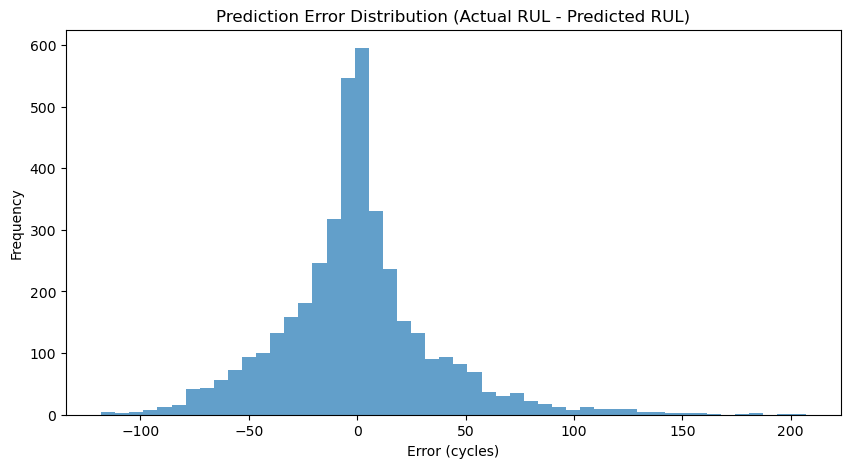

In [8]:
plt.figure(figsize=(10,5))
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Prediction Error Distribution (Actual RUL - Predicted RUL)")
plt.xlabel("Error (cycles)")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Add engine_id back to X_test
X_test_with_id = X_test.copy()
X_test_with_id['engine_id'] = df.loc[X_test.index, 'engine_id']
X_test_with_id['actual_RUL'] = y_test
X_test_with_id['pred_RUL'] = y_pred

engine_errors = X_test_with_id.groupby('engine_id').apply(
    lambda x: np.sqrt(np.mean((x['actual_RUL'] - x['pred_RUL'])**2))
)

engine_errors.head()


C:\Users\jaron\AppData\Local\Temp\ipykernel_5796\2284502343.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  engine_errors = X_test_with_id.groupby('engine_id').apply(


engine_id
1    48.647724
2    24.432872
3    22.401828
4    34.116268
5    18.505880
dtype: float64

In [10]:
bad_engine = engine_errors.sort_values(ascending=False).index[0]
bad_engine


np.int64(69)

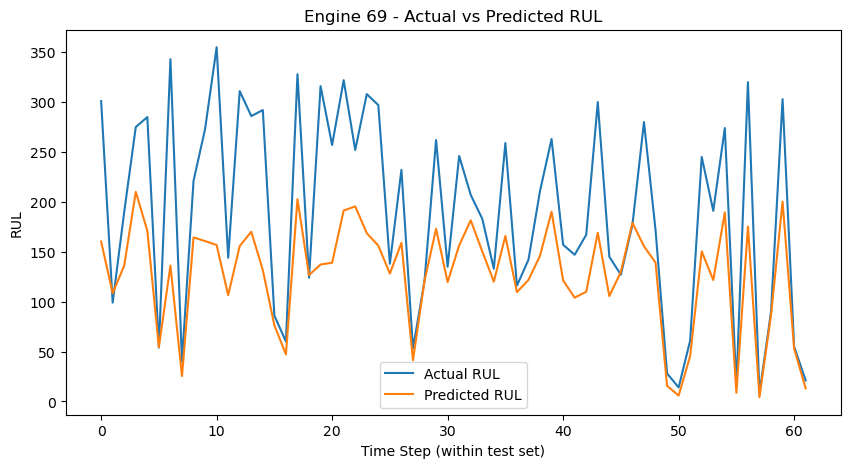

In [11]:
engine_data = X_test_with_id[X_test_with_id['engine_id'] == bad_engine]

plt.figure(figsize=(10,5))
plt.plot(engine_data['actual_RUL'].values, label="Actual RUL")
plt.plot(engine_data['pred_RUL'].values, label="Predicted RUL")
plt.title(f"Engine {bad_engine} - Actual vs Predicted RUL")
plt.xlabel("Time Step (within test set)")
plt.ylabel("RUL")
plt.legend()
plt.show()


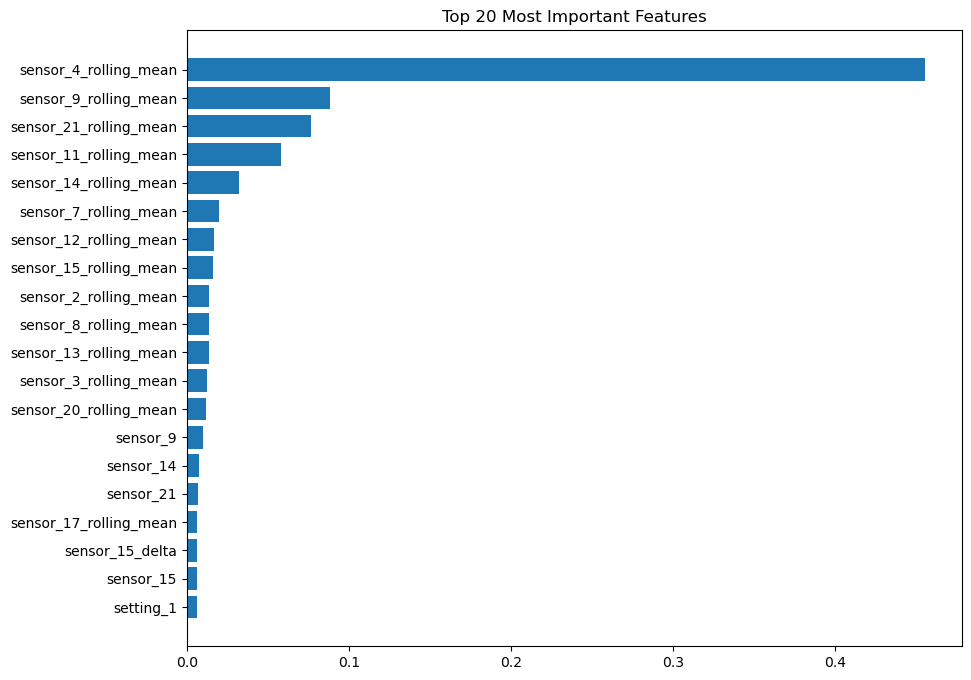

In [12]:
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features

plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.title("Top 20 Most Important Features")
plt.show()
